# Organize ML projects with Scikit-Learn

While Machine Learning is powerful, people often overestimate it: apply machine learning to your project, and all your problems will be solved. In reality, it's not this simple. To be effective, one needs to organize the work very well. In this notebook, we will walkthrough practical aspects of a ML project. To look at the big picture, let's start with a checklist below. It should work reasonably well for most ML projects, but make sure to adapt it to your needs:

1. **Define the scope of work and objective**
    * How is your solution be used?
    * How should performance be measured? Are there any contraints?
    * How would the problem be solved manually?
    * List the available assumptions, and verify if possible.
    
    
2. **Get the data**
    * Document where you can get that data
    * Store data in a workspace you can easily access
    * Convert the data to a format you can easily manipulate
    * Check the overview (size, type, sample, description, statistics)
    * Data cleaning
    
    
3. **EDA & Data transformation**
    * Study each attribute and its characteristics (missing values, type of distribution, usefulness)
    * Visualize the data
    * Study the correlations between attributes
    * Feature selection, Feature Engineering, Feature scaling
    * Write functions for all data transformations
    
    
4. **Train models**
    * Automate as much as possible
    * Train promising models quickly using standard parameters. Measure and compare their performance
    * Analyze the errors the models make
    * Shortlist the top three of five most promising models, preferring models that make different types of errors.


5. **Fine-tunning**
    * Treat data transformation choices as hyperparameters, expecially when you are not sure about them (e.g., replace missing values with zeros or with the median value)
    * Unless there are very few hyperparameter value to explore, prefer random search over grid search.
    * Try ensemble methods
    * Test your final model on the test set to estimate the generalizaiton error. Don't tweak your model again, you would start overfitting the test set.

## Example: Articles categorization

### Objectives

Build a model to determine the categories of articles. 

### Get Data

In [ ]:
import os
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
layers = keras.layers
models = keras.models
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")

In [ ]:
bbc = pd.read_csv('https://raw.githubusercontent.com/dhminh1024/practice_datasets/master/bbc-text.csv')

In [ ]:
bbc.sample(5)

,category,text
2029,tech,friends fear with lost mobiles people are bec...
1538,politics,no election tv debate says blair tony blair h...
89,business,bank set to leave rates on hold uk interest ra...
1672,sport,real will finish abandoned match real madrid a...
1848,politics,mps murder sentence concern murder sentences ...


In [ ]:
bbc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   text      2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


In [ ]:
bbc.describe()

,category,text
count,2225,2225
unique,5,2126
top,sport,queen recruit singer for new tour the remainin...
freq,511,2


In [ ]:
from sklearn.model_selection import train_test_split
X = bbc[['category']]
y = bbc[['text']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=102)

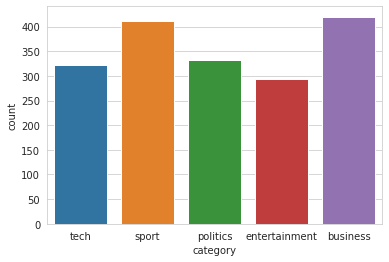

In [ ]:
sns.countplot(x='category', data=X_train)

In [ ]:
bbc['category'].value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

In [ ]:
# Your code here
train_size = int(len(bbc) * .8)
print ("Train size: %d" % train_size)
print ("Test size: %d" % (len(bbc) - train_size))

Train size: 1780
Test size: 445


In [ ]:
def train_test_split(bbc, train_size):
    train = bbc[:train_size]
    test = bbc[train_size:]
    return train, test

In [ ]:
train_cat, test_cat = train_test_split(bbc['category'], train_size)
train_text, test_text = train_test_split(bbc['text'], train_size)

In [ ]:
max_words = 1000
tokenize = keras.preprocessing.text.Tokenizer(num_words=max_words, 
                                              char_level=False)

In [ ]:
tokenize.fit_on_texts(train_text) # fit tokenizer to our training text data
x_train = tokenize.texts_to_matrix(train_text)
x_test = tokenize.texts_to_matrix(test_text)

In [ ]:
#Sử dụng sklearn để chuyển đổi chuỗi nhãn thành chỉ mục được đánh số
encoder = LabelEncoder()
encoder.fit(train_cat)
y_train = encoder.transform(train_cat)
y_test = encoder.transform(test_cat)

In [ ]:
#Chuyển đổi các nhãn thành một đại diện đơn nhất
num_classes = np.max(y_train) + 1
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [ ]:
#Kiểm tra kích thước của dữ liệu train
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

x_train shape: (1780, 1000)
x_test shape: (445, 1000)
y_train shape: (1780, 5)
y_test shape: (445, 5)


In [ ]:
#training
batch_size = 32
epochs = 2
drop_ratio = 0.5

In [ ]:
# Build model
model = models.Sequential()
model.add(layers.Dense(512, input_shape=(max_words,)))
model.add(layers.Activation('relu'))
# model.add(layers.Dropout(drop_ratio))
model.add(layers.Dense(num_classes))
model.add(layers.Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Epoch 1/2
51/51 [==============================] - 0s 8ms/step - loss: 0.4180 - accuracy: 0.8864 - val_loss: 0.1384 - val_accuracy: 0.9551
Epoch 2/2
51/51 [==============================] - 0s 5ms/step - loss: 0.0390 - accuracy: 0.9938 - val_loss: 0.1302 - val_accuracy: 0.9494


In [ ]:
#Đánh giá độ chính xác của mô hình được đào tạo
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

14/14 [==============================] - 0s 3ms/step - loss: 0.1372 - accuracy: 0.9596
Test loss: 0.1372355818748474
Test accuracy: 0.9595505595207214


In [ ]:
def run_experiment(batch_size, epochs, drop_ratio):
  print('batch size: {}, epochs: {}, drop_ratio: {}'.format(
      batch_size, epochs, drop_ratio))
  model = models.Sequential()
  model.add(layers.Dense(512, input_shape=(max_words,)))
  model.add(layers.Activation('relu'))
  model.add(layers.Dropout(drop_ratio))
  model.add(layers.Dense(num_classes))
  model.add(layers.Activation('softmax'))

  model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
  history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=0,
                    validation_split=0.1)
  score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=0)
  print('\tTest loss:', score[0])
  print('\tTest accuracy:', score[1])

In [ ]:
batch_size = 16
epochs = 4
drop_ratio = 0.4
run_experiment(batch_size, epochs, drop_ratio)

batch size: 16, epochs: 4, drop_ratio: 0.4
	Test loss: 0.13897603750228882
	Test accuracy: 0.9505618214607239


In [ ]:
#dự đoán
text_labels = encoder.classes_ 

for i in range(10):
    prediction = model.predict(np.array([x_test[i]]))
    predicted_label = text_labels[np.argmax(prediction)]
    print(test_text.iloc[i][:50], "...")
    print('Actual label:' + test_cat.iloc[i])
    print("Predicted label: " + predicted_label + "\n")

hobbit picture  four years away  lord of the rings ...
Actual label:entertainment
Predicted label: entertainment

game firm holds  cast  auditions video game firm b ...
Actual label:tech
Predicted label: tech

clarke plans migrant point scheme anyone planning  ...
Actual label:politics
Predicted label: politics

radcliffe will compete in london paula radcliffe w ...
Actual label:sport
Predicted label: sport

serena becomes world number two serena williams ha ...
Actual label:sport
Predicted label: sport

ultimate game  award for doom 3 sci-fi shooter doo ...
Actual label:tech
Predicted label: tech

algeria hit by further gas riots algeria suffered  ...
Actual label:business
Predicted label: business

fast lifts rise into record books two high-speed l ...
Actual label:tech
Predicted label: business

muslim group attacks tv drama 24 a british muslim  ...
Actual label:entertainment
Predicted label: entertainment

us tv special for tsunami relief a us television n ...
Actual label:entertai

In [ ]:
y_softmax = model.predict(x_test)

y_test_1d = []
y_pred_1d = []

for i in range(len(y_test)):
    probs = y_test[i]
    index_arr = np.nonzero(probs)
    one_hot_index = index_arr[0].item(0)
    y_test_1d.append(one_hot_index)

for i in range(0, len(y_softmax)):
    probs = y_softmax[i]
    predicted_index = np.argmax(probs)
    y_pred_1d.append(predicted_index)

In [ ]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

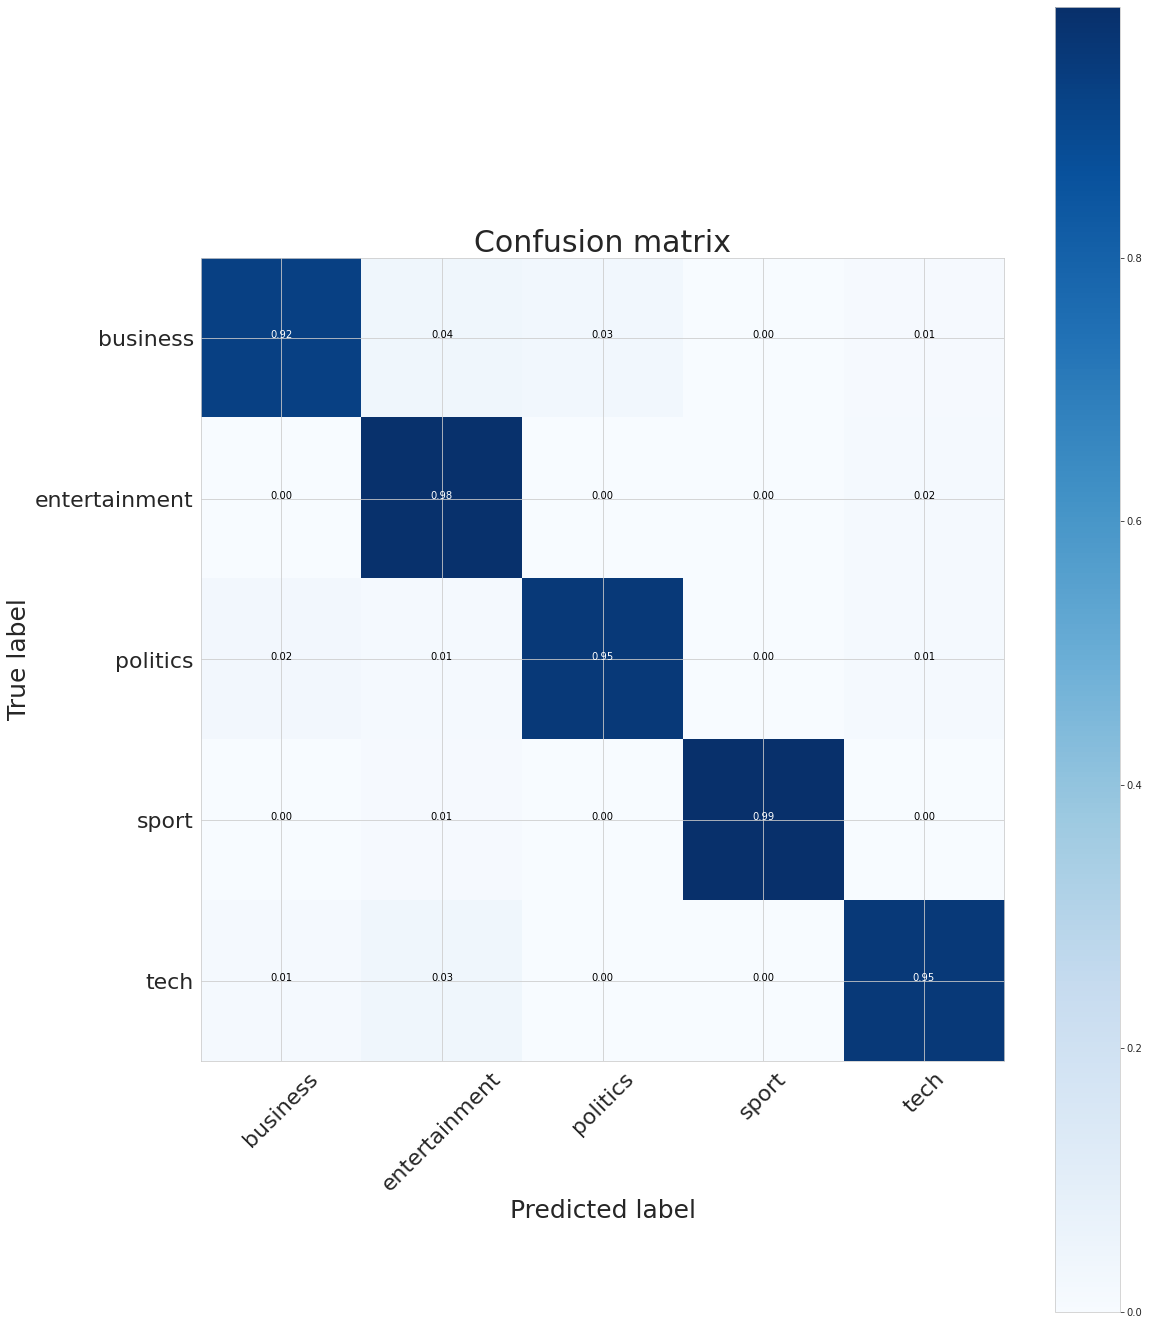

In [32]:
cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(18,24))
plot_confusion_matrix(cnf_matrix, classes=text_labels, title="Confusion matrix")
plt.show()